**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1802]:
import matplotlib.pyplot as plt
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
T=True
F=False
import pandas as pd
from itertools import combinations
from operator import itemgetter
from sklearn.base import clone,is_classifier
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate,check_cv,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import copy

import re
def getPrivateAttr(obj,private_begin="__",private_end="[^_]",private_suffixe=""):
    dd=re.compile("^"+private_begin+private_suffixe+".+"+private_end+"$")
    return {j:getattr(obj,str(j)) for j in [i for i in dir(obj) if dd.match(i)]}

def new_models(models):
    return [(i,clone(k)) for i,k in models]
def diff_classif_models(models,X_test=X_test,y_test=y_test,names=None):
    names=[ i.__class__.__name__ for i in models] if names is None else  names
    kkd=[ y_test!=i.predict(X_test) for i in models]
    combi=list(combinations(range(len(names)),2))
    o=np.zeros((len(names),len(names)))
    o2=np.zeros((len(names),len(names)))
    o3=np.full((len(names),len(names),np.shape(X_test)[0]),-1,dtype="O")
    for (i,j) in combi:
        o[i][j]=(kkd[i]*kkd[j]).sum()
        o2[i][j]=o[i][j]/(kkd[i] | kkd[j]).sum()
        if((o3[i][i]==-1).all()): o3[i][i]=kkd[i]
        if((o3[j][j]==-1).all()): o3[j][j]=kkd[j]
        o3[i][j]=kkd[i]*kkd[j]
        o3[j][i]=kkd[i]*kkd[j]
    return [pd.DataFrame(o,columns=names,index=names),pd.DataFrame(o2,columns=names,index=names),o3,kkd]

class case(object):
    def __init__(self,j,i,k):
        self.i=i
        self.j=j
        self.k=k
    def __repr__(self):
        return "'[Case] ligne {}, colonne {}, valeur {}'".format(self.i,self.j,self.k)
    def __str__(self):
        return self.__repr__()
    @classmethod
    def fromArr(cls,arr):
        return [cls(i,j,k) for i,j,k in arr]
    
class caseConfusionMat(case):
    def __init__(self,i,j,k,names=None):
        self.i=i
        self.j=j
        self.k=k
        self.ni=i if names is None else names[i]
        self.nj=j if names is None else names[j]
    def __repr__(self):
        return "[CaseConfMat] Il y a {} observations de classe '{}' predite en classe '{}'".format(self.k,self.ni,self.nj)
    @classmethod
    def fromArr(cls,arr,names=None):
        return [cls(i,j,k,names) for i,j,k in arr]
    
class caseConfusionGlobal(case):
    def __init__(self,ie,names=None,typeG=0):
        i=dict(ie)
        self.typeG=typeG
        self.i=i.items()
        self.ni=list(i.keys()) if names is None else names[i.keys()]
    def eachR(self,ni,k):
        typeG=self.typeG
        st=""
        if typeG==0:
            st="[CaseConfGlobal] Classe Actuelle '{}': '{}' mauvaise predictions (prediction de ≠ classes pour cette classe)"
        else:
            st="[CaseConfGlobal] Prediction Classe '{}': '{}' mauvaise predictions (prediction pour d'autres classes)"
        return  st.format(ni,k)
    def __repr__(self,typeG=0):
        return "\n\t".join([self.eachR(self.ni[_i],k) for _i,(i,k) in enumerate(self.i)])
    @classmethod
    def fromArr(cls,arr,names=None):
        return [cls(i,names,_i) for _i,i in enumerate(arr)]
    
def most_confused(pred,true,min_val=1,classes=None,lim=100,shuffle=None):
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        classes=np.unique(np.concatenate([pred,true]))
        cm = confusion_matrix(true,pred)
        np.fill_diagonal(cm, 0)
        res = [(classes[i],classes[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return (sorted(res, key=itemgetter(2), reverse=True)[:lim],len(res)-lim if len(res)>lim else False)
def getObsMostConfused(classe,predit,X,y,pred,lim=10):
    return np.array(X)[(y==classe) & (predit==pred)][:lim]
def most_confused_global(pred,true,classes=None,lim=100):
    classes=np.unique(np.concatenate([pred,true]))
    cm = confusion_matrix(true,pred)
    np.fill_diagonal(cm, 0)
    lignes=sorted(list(enumerate(np.sum(cm,axis=1))),key=itemgetter(1), reverse=True)[:lim]
    cols=sorted(list(enumerate(np.sum(cm,axis=0))),key=itemgetter(1), reverse=True)[:lim]
    return ([lignes,cols],len(lignes)-lim if len(cols)>lim else False)
def plot_confusion_matrix2(pred,true,classes=None,normalize:bool=False, title:str='Confusion matrix', cmap="Blues", slice_size=1,
                              norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        if classes is None:
            classes = np.unique(np.concatenate([pred,true]))
        cm = confusion_matrix(true,pred)
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('Actuelle')
        plt.xlabel('Predite')
        plt.grid(False)
        fig
def _cross_val_score2(est,train,test,x_test,y_test,name):
    s=[i.score(x_test, y_test) for i in est]
    score2=list(zip(train,test,s))
    df=np.round(pd.DataFrame(score2,columns=["train","validation","test"]),2)
    df.index.name="CV"
    df=pd.concat([df,df.apply(np.mean,axis=0).rename('mean').to_frame().T],axis=0)
    df=pd.concat([df,df.apply(np.std,axis=0).rename('std').to_frame().T],axis=0)
    return (est,(name+"\n"+np.round(df,2).to_string()).replace("\n","\n\t"))
def cross_val_score2(es,X=X_train,y=y_train,x_test=X_test,y_test=y_test,cv=5,verbose=False,names=None):
    if isinstance(cv,check_cv2): cv=cv.splited
    names=uniquify([i.__class__.__name__ for i in es]) if names is None else names
    es=np.array(es, dtype=object).flatten()
    if(cv==1):
        k=[i.fit(X_train,y_train) for i in es]
        d=[_cross_val_score2([i],[i.score(X_train,y_train)],[0],x_test,y_test,names[j]) for j,i in enumerate(es)]
        print("\n\n".join([i[1] for i in d]))
        return [i[0] for i in d]
    cvS=[cross_validate(i,X,y,n_jobs=-1,cv=cv,return_estimator=True,return_train_score=True,verbose=verbose) for i in es]
    d=[_cross_val_score2(i["estimator"],i["train_score"],i["test_score"],x_test,y_test,names[j]) for j,i in enumerate(cvS)]
    print("\n\n".join([i[1] for i in d]))
    return [i[0] for i in d]
class check_cv2:
    def __init__(self,X,y,cv_=3,classifier=True,random_state=42,shuffle=True):
        self.cv_=cv_
        self.y=y
        self.X=X
        self.classifier=classifier
        self.random_state=random_state
        self.shuffle=shuffle
        self.splited=self.split()
    def split(self,*args):
        e=check_cv(self.cv_,self.y,classifier=self.classifier)
        e.shuffle=self.shuffle
        return list(e.split(self.X,self.y))
    
                           
def cross_fn_cv(fn,cv,X=None,y=None):
    if isinstance(cv,check_cv2):
        if X is None:
            X = cv.X
        if y is None:
            y = cv.y

        vc=cv.split()
    else:
        assert X is not None 
        assert Y is not None
        vc=cv
    return [fn(X[i],y[i],X[j],y[j]) for (i,j) in vc] 
from collections import Counter # Counter counts the number of occurrences of each item
from itertools import tee, count

def uniquify(seq2, suffs = count(1)):
    """Make all the items unique by adding a suffix (1, 2, etc).

    `seq` is mutable sequence of strings.
    `suffs` is an optional alternative suffix iterable.
    """
    seq=seq2
    not_unique = [k for k,v in Counter(seq).items() if v>1] # so we have: ['name', 'zip']
    # suffix generator dict - e.g., {'name': <my_gen>, 'zip': <my_gen>}
    suff_gens = dict(zip(not_unique, tee(suffs, len(not_unique))))  
    for idx,s in enumerate(seq):
        try:
            suffix = str(next(suff_gens[s]))
        except KeyError:
            # s was unique
            continue
        else:
            seq[idx] += suffix
    return seq
def zipl(*args):
    return list(zip(*args))
def filterl(*args):
    return list(filter(*args))
def rangel(*args):
    return list(range(*args))
def ifEmptySet(s,li):
    return s if len(li)==0 else li
def remove_empty_keys(d):
    for k in list(d.keys()):
        if not d[k]:
            del d[k]
    return d
import warnings
def offWarnings():
    warnings.filterwarnings('ignore')
def onWarnings(d="default"):
    warnings.filterwarnings('default')
def removeNone(arr):
    return [i for i in arr if i is not None]
class modErr:
    def __init__(self,arr,names,noEmpty=False):
        self.arr=arr
        self.names=names
        self.noEmpty=noEmpty
    def printM(self,arr,m):
        if self.noEmpty and len(arr)==0: return None
        a=str(m)
        a+="\t"+np.array2string(arr,separator=", ")
        return a
    def __repr__(self):
        return "\n".join(removeNone([self.printM(np.where(j)[0],self.names[i]) for i,j in enumerate(self.arr)]))

class loadFnIfCallOrSubset:
    def __init__(self,selfo,fn):
        self.fn=fn
        self.selfo=selfo
    def __getitem__(self,i):
        self.selfo=self.fn()
        return self.selfo[i]
class tg:
    def __init__(self,i):
        self.i=i
    def __repr__(self):
        return ""
class mostConfGlobL:
    def __init__(self,d,lignes=True):
        self.lignes=lignes
        self.d=d
    def __repr__(self):
        n="Actuelle" if self.lignes else "Predite"
        oo=self.d.items()
        jj=[]
def printArr(arr,noPrint=False):
    stre="\n".join([ "\t"+str(i) for i in arr])
    if not noPrint: print(stre)
    return arr if not noPrint else stre
def printMostConfGlob(arr,noPrint=False):
    ne=["ACTUELLE","PRÉDITE"]
    stre="\n".join([ "\n\t"+ne[_i]+"\n\t"+str(i) for _i,i in enumerate(arr)])
    if not noPrint: print(stre)
    return arr if not noPrint else stre
    
def printDico(dico,fn=lambda a,*args,**xargs:a,moreAdd=None,more="\n(+ {})"):
    moreAdd = [False]*len(dico.keys()) if moreAdd is None else  moreAdd
    oo=[ i+"\n"+fn(j,noPrint=True) for i,j in dico.items()]
    oo=[i+more.format(moreAdd[_i]) if moreAdd[_i] else i for _i,i in enumerate(oo)]
    print("\n\n".join(oo))
    return dico
def isInt(i):
    return isinstance(i,int)
def isStr(i):
    return isinstance(i,str)
def isNumpyArr(i):
    return isinstance(i,np.ndarray)
def ifOkDoFn(i,ok,fn):
    return fn(i) if ok else i            
def flatArray(arr):
    return np.array([arr]).flatten()
def getClassName(i):
    return i.__class__.__name__
class studyNpArray(np.ndarray):
    def __new__(cls, array, **kwargs):
        obj = np.asarray(array).view(cls)                                 
        for i,j in kwargs.items():
            obj.__setattr__(i,j)
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        kwargs=getPrivateAttr(obj,private_suffixe="study")
        for i,j in kwargs.items():
            self.__setattr__(i,j)
                           
def studyDico(dico,**args):
    dico=StudyClassifDict(dico)
    for i,j in args.items():
        dico.__setattr__(i,j)
    return dico
def studyList(dico,**args):
    dico=StudyClassifList(dico)
    for i,j in args.items():
        dico.__setattr__(i,j)
    return dico
from collections import UserDict,UserList
class StudyClassifDict(UserDict):
    def __getitem__(self, key):
        key=list(self.keys())[key] if isInt(key) else key
        if key in self.data:
            rep = self.data[key]
            atty=getPrivateAttr(self,private_suffixe="study")
            if isinstance(rep,list):
                return studyList(rep,**atty)
            elif isNumpyArr(rep):
                rep=studyNpArray(rep,**atty)
                return rep
            else:
                raise "PB"
        if hasattr(self.__class__, "__missing__"):
            return self.__class__.__missing__(self, key)
        raise KeyError(key)
class StudyClassifList(UserList): pass
class studyClassif:
    def __init__(self,models,X_test=X_test,y_test=y_test,names=None):
        offWarnings()
        self.X_test=X_test
        self.y_test=y_test
        self.namesCls=names
        self._init(models)
                           
    def _init(self,models):
        self.models=flatArray([models])
        self.names=np.array(uniquify([getClassName(i) for i in self.models]))
        self.inames=np.array(rangel(len(self.models)))
        self.namesi=dict(zip(self.names,self.inames))
        self.diff=None
        self.diff=loadFnIfCallOrSubset(self.diff,lambda:self.diff_classif_models())
                           
    def getIndexFromNames(self,arr,returnOK=True):
        return [self.namesi[i] if isStr(i) else i for i in arr] if returnOK else None
                           
    def diff_classif_models(self,returnOK=True):
        return diff_classif_models(self.models,self.X_test,self.y_test,self.names) if returnOK else None
                           
    def most_confused(self,min_val=1,noEmpty=False,classNames=True,lim=100,shuffle=False,
                     globally=False,returnOK=False):
        if not globally:
            offWarnings()
            res= {i+" (N°"+str(o)+")" :most_confused(self.y_test,j.predict(self.X_test),min_val=min_val,lim=lim,shuffle=shuffle)  for o,(i,j) in enumerate(zipl(self.names,self.models))}
            moreS=[j[1] for i,j in res.items()]
            res={i:caseConfusionMat.fromArr(j[0],self.namesCls if classNames else None ) for i,j in res.items()}
            onWarnings()
            res=remove_empty_keys(res) if noEmpty else res
            o= printDico(res,fn=printArr,moreAdd=moreS)
        else:
            allPred=[[self.y_test,j.predict(self.X_test)]  for o,(i,j) in enumerate(zipl(self.names,self.models))]
            allPredN=np.hstack(allPred)
            res=most_confused(allPredN[0],allPredN[1],min_val=min_val,lim=lim,shuffle=shuffle) 
            moreS=[res[1]]
            res={"globally":caseConfusionMat.fromArr(res[0],self.namesCls if classNames else None )}
            res=remove_empty_keys(res) if noEmpty else res
            o= printDico(res,fn=printArr,moreAdd=moreS)
        return o if returnOK else None 
                           
    def plot_conf_matrix(self,m=[],returnOK=False):
        mm=flatArray(m)
        mm=self.getIndexFromNames(mm)
        zizi=zipl(self.names[mm],self.models[mm]) if len(mm)>0 else zipl(self.names,self.models)          
        o= [ plot_confusion_matrix2(self.y_test,j.predict(self.X_test),title=i,classes=self.namesCls) for (i,j) in zizi]
        return o if returnOK else None  
                           
    def getModelsErrors(self,m=[],noEmpty=False,returnOK=False):
        o3=self.diff[2]
        mm=flatArray(m)
        mm=self.getIndexFromNames(mm)
        o33=[o3[i][i] for i in range(np.shape(o3)[0])]
        o= modErr(o33 if len(mm) == 0 else np.array(o33)[mm] ,self.names if len(mm) == 0 else self.names[mm],noEmpty=noEmpty)
        return o if returnOK else None
    def getModelsSameErrors(self,m=[],pct=False,noEmpty=False,returnOK=True):
        o3=self.diff[0]
        mm=flatArray(m)
        mm=self.getIndexFromNames(mm)
        if pct:
            o3 = self.diff[1]
        o3=o3 if len(mm)==0 else o3.iloc[mm,mm]
        return o3 if returnOK else None
                           
    def cross_val_score2(self,X_train=None,y_train=None,m=[],cv=3,verbose=0,returnNewStudy=False,returnOK=False):
        mm=flatArray(m)
        mm=self.getIndexFromNames(mm)
        cv = cross_val_score2(self.models if len(mm)==0 else self.models[mm],X_train,y_train,self.X_test,self.y_test,cv=cv,verbose=verbose,names=self.names if len(mm)==0 else self.names[mm])
        if returnNewStudy: 
            return (cv,self.updateModels(cv)) if  returnOK else self.updateModels(cv)
        else : 
            return cv if returnOK else None
                           
    def updateModels(self,models):
        me=copy.deepcopy(self)
        me._init(models)
        return me
                           
    def classification_report(self,globally=False,returnOK=False):
        if globally:
            allPred=[[self.y_test,j.predict(self.X_test)]  for (i,j) in zipl(self.names,self.models)]
            allPredN=np.hstack(allPred)
            o=printDico({"globally":classification_report(allPredN[0],allPredN[1])})
        else:
            o=printDico({i:classification_report(self.y_test,j.predict(self.X_test)) for (i,j) in zipl(self.names,self.models)})
        return o if returnOK else None
   
    def most_confused_global(self,lim=10,classNames=True,returnOK=False):
        res= {i+" (N°"+str(o)+")" :most_confused_global(self.y_test,j.predict(self.X_test),lim=lim)  for o,(i,j) in enumerate(zipl(self.names,self.models))}
        moreS=[j[1] for i,j in res.items()]
        res={i:caseConfusionGlobal.fromArr(j[0],self.namesCls if classNames else None ) for i,j in res.items()}
        o=printDico(res,fn=printMostConfGlob,moreAdd=moreS)
        return o if returnOK else None
    
    def getObsConfused(self,classe,predit,m=[],lim=10,printOk=False,returnOK=True,shuffle=True):
        mm=flatArray(m)
        mm=self.getIndexFromNames(mm)
        zz=zipl(self.names,self.models) if len(mm)==0 else zipl(self.names[mm],self.models[mm])
        o=studyDico({i:getObsMostConfused(classe,predit,self.X_test,self.y_test,j.predict(self.X_test),lim=lim) for i,j in zz},
                    __study_i=classe,__study_j=predit,__study=self)
        if printOk: printDico(o,fn=printArr)
        return o if returnOK else None


1 ligne,  
0 col

In [1141]:
studyClassif1 = studyClassif([rnd_clf],names=np.array(["fleur","poney","scie"]))
studyClassif1.most_confused(noEmpty=True,classNames=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

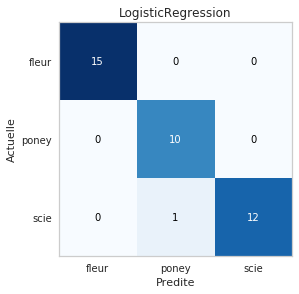

In [947]:
studyClassif1.plot_conf_matrix(["LogisticRegression"])

In [949]:
studyClassif1.getModelsErrors([1,3],noEmpty=True) 

LogisticRegression	[15]

In [1820]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

class studyClassif_Img:
    @staticmethod
    def plotImgsMultiClassif(im,title="",nr=2,nc=5,figsize=(9,5),w=28,h=28,titleSize=29,m=[],reshape=False):
        mm=flatArray(m)
        mm=getattr(im,"__study").getIndexFromNames(mm)
        names=getattr(im,"__study").names
        names = names if len(mm)==0 else names[mm]
        uu=studyClassif_Img.reshapeMultiClassif(im,w,h)  if reshape else im
        uu = uu if len(mm) ==0 else np.array(uu)[mm]
        for i in range(len(uu)):
            studyClassif_Img.plotImgs(im[i],names[i]+"\n",nr,nc,figsize,w,h,titleSize,not reshape,addToTitle=T)
        
    @staticmethod
    def plotImgs(im,title="",nr=2,nc=5,figsize=(9,5),w=28,h=28,titleSize=29,reshape=True,addToTitle=False):
        uu=studyClassif_Img.reshape(im,w,h) if reshape else im
        title_ = "Classe {} prédit en {}".format(getattr(im,"__study_i"),getattr(im,"__study_j"))
        if (len(title)==0) or (len(title) >0 and addToTitle): title=title+title_ 
        plt.figure(figsize=figsize)
        for _i,i in enumerate(uu): 
            plt.subplot(nr,nc,_i+1)
            plt.imshow(i)
            plt.axis('off')
        plt.suptitle(title,size=titleSize);
        
    @staticmethod
    def reshapeMultiClassif(im,w=28,h=28):
        return [studyClassif_Img.reshape(j,w,h) for ww,j in im.items()]
    
    @staticmethod
    def reshape(im,w=28,h=28):
        return [i.reshape(w,h) for i in im]

# Voting classifiers

In [656]:
%matplotlib inline

In [657]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


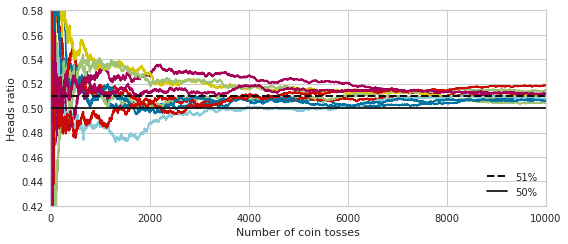

In [658]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [659]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(iris["data"], iris.target, random_state=42)

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [660]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

mod=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]
votingH_clf = VotingClassifier(estimators=new_models(mod),voting='hard')
voting_clf = VotingClassifier(estimators=new_models(mod),voting='soft')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [661]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, votingH_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression 0.9736842105263158
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


Soft voting:

In [662]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport,ConfusionMatrix,confusion_matrix as cm
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


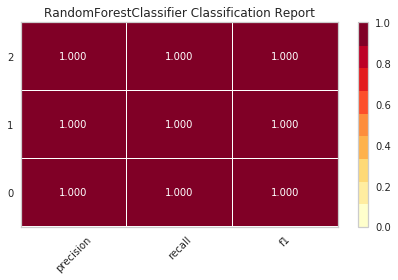

In [663]:
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression

model = RandomForestClassifier()
visualizer = ClassificationReport(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


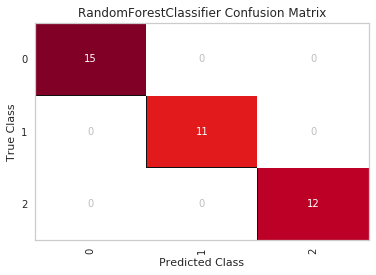

In [664]:
logReg = RandomForestClassifier()
visualizer = ConfusionMatrix(logReg)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
g = visualizer.poof()

In [665]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

#voting_clf.fit(X_train, y_train)

In [666]:
voting_clf = VotingClassifier(
    estimators=[('lr', clone(log_clf)), ('rf', clone(rnd_clf)), ('svc', clone(svm_clf)),
             ("ba",clone(bag_clf))],
    voting='soft')

In [667]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, votingH_clf,voting_clf,voting_clf2,bag_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression 0.9736842105263158
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


VotingClassifier 1.0
VotingClassifier 1.0


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


BaggingClassifier 1.0


In [711]:
studyClassif1 = studyClassif([rnd_clf,svm_clf,bag_clf,log_clf])
studyClassif1.most_confused()

In [712]:
studyClassif1.most_confused()

TypeError: zip argument #2 must support iteration

[None, None, None, None]

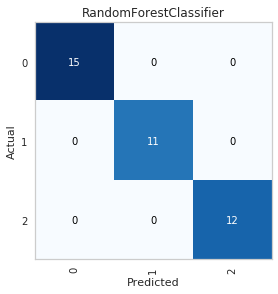

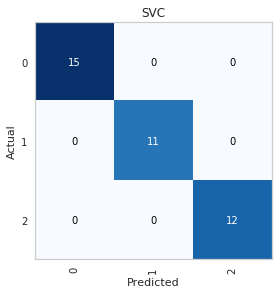

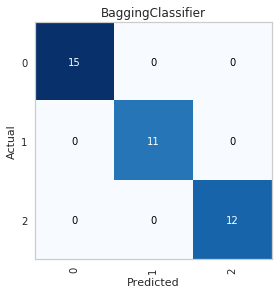

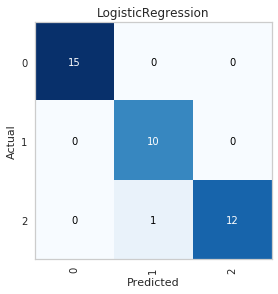

In [688]:
studyClassif1.plot_conf_matrix()

In [374]:
dif=diff_classif_models((log_clf, rnd_clf, svm_clf, votingH_clf,voting_clf,voting_clf2,bag_clf))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


[None, None, None, None, None, None, None]

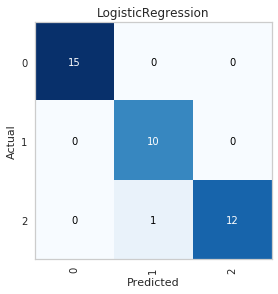

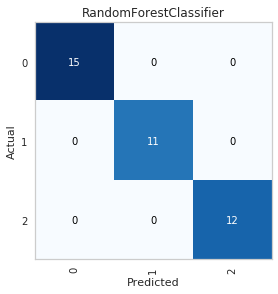

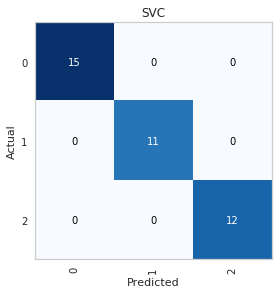

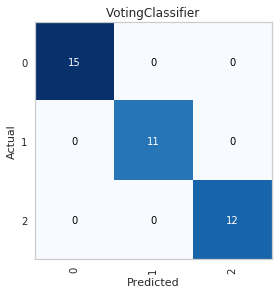

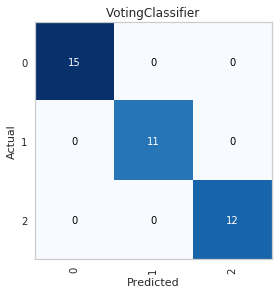

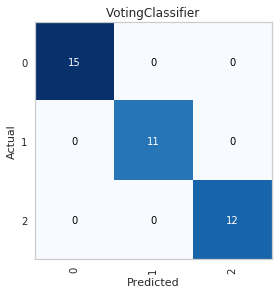

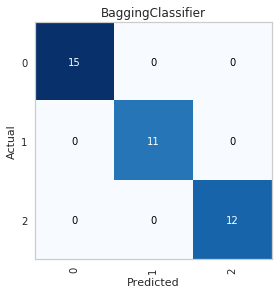

In [324]:
[ plot_confusion_matrix2(y_test,i.predict(X_test),title=i.__class__.__name__) for i in (log_clf, rnd_clf, svm_clf, votingH_clf,voting_clf,voting_clf2,bag_clf)]
                         

In [24]:
#!pip install mlens 

In [117]:
from mlens.ensemble import SuperLearner
from sklearn import clone

In [118]:
ensemble = SuperLearner(scorer=accuracy_score,
                        random_state=42,n_jobs=-1,shuffle=True)

In [139]:
bag_clf.fit

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [119]:
ensemble = SuperLearner(scorer=accuracy_score,n_jobs=-1,shuffle=False)
# Build the first layer
ensemble.add([('lr', clone(log_clf)), ('rf', clone(rnd_clf)), ('svc', clone(svm_clf)),
             ("vot",clone(voting_clf)),clone(bag_clf)])
# Build the second layer

# Attach the final meta estimator
ensemble.add_meta(RandomForestClassifier())

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...0d4598>)],
   n_jobs=-1, name='group-62', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function accuracy_score at 0x7f81fd0d4598>, shuffle=False,
       verbose=False)

In [120]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf,votingH_clf,bag_clf, voting_clf,ensemble):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912
BaggingClassifier 0.904
VotingClassifier 0.92


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/mlens/parallel/_base_functions.py:313: ParameterChangeWarning: Parameter value (10) has changed since model was fitted ('warn').
  (lpar, rpar), ParameterChangeWarning)
/opt/conda/lib/python3.7/site-packages/mlens/parallel/_base_functions.py:313: ParameterChangeWarning: Parameter value (10) has changed since model was fitted ('warn').
  (lpar, rpar), ParameterChangeWarning)


SuperLearner 0.896


# Bagging ensembles

In [634]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, bootstrap=True)

In [635]:
cv1=check_cv2(X_train,y_train,5)

In [636]:
cross_val_score2(bag_clf,cv=cv1);

      train  validation  test
0       1.0        0.91   1.0
1       1.0        0.91   1.0
2       1.0        0.91   1.0
3       1.0        1.00   1.0
4       1.0        0.95   1.0
mean    1.0        0.94   1.0
std     0.0        0.03   0.0


In [639]:
tree_clf = DecisionTreeClassifier(random_state=42)
cross_val_score2(tree_clf,cv=cv1);

      train  validation  test
0       1.0        0.87  0.95
1       1.0        0.91  1.00
2       1.0        0.91  1.00
3       1.0        1.00  1.00
4       1.0        0.95  1.00
mean    1.0        0.93  0.99
std     0.0        0.04  0.02


In [640]:
def train_study(Xtr,yTr,Xte,yTe,model):
    models=np.array([model]).flatten()
    models=[i.fit(Xtr,yTr) for i in models]
    return studyClassif(models,Xte,yTe)

In [650]:
resu=cross_fn_cv(lambda a,b,c,d:train_study(a,b,c,d,[bag_clf,tree_clf]),cv1)

In [641]:
stu=train_study(X_train,y_train,X_test,y_test,[bag_clf,tree_clf])

In [649]:
stu.diff_classif_models()[3]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False])]

In [652]:
[i.diff_classif_models()[1] for i in resu]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


[array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 0.],
        [0., 0.]]), array([[0., 4.],
        [0., 0.]])]

In [409]:
studyClassifDec=studyClassif([tree_clf])

In [410]:
studyClassifDec.most_confused()

[[]]

In [196]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

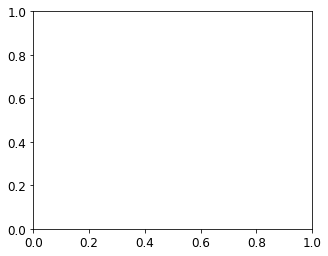

In [197]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

# Random Forests

In [396]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [397]:
#bag_clf.fit(X_train, y_train)
cross_val_score2(bag_clf)

NameError: name 'cross_validate' is not defined

In [308]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
cross_val_score2(rnd_clf)

      train  validation  test
0      0.95        0.91  0.91
1      0.96        0.95  0.90
2      0.96        0.88  0.90
3      0.96        0.96  0.91
4      0.98        0.89  0.91
mean   0.96        0.92  0.91
std    0.01        0.03  0.00


In [18]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

In [277]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [310]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

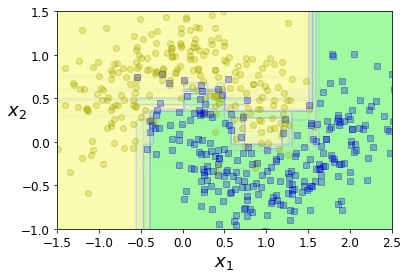

In [311]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Out-of-Bag evaluation

In [312]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [313]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [314]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## Feature importance

In [950]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [1804]:
X_train,X_test, y_train, y_test = train_test_split(mnist.data,mnist.target,random_state=42,test_size=0.7)

In [1805]:
rnd_clf = RandomForestClassifier(n_estimators=50, random_state=42,n_jobs=-1)
log_clf = LogisticRegression(n_jobs=-1,tol=0.05)

In [1422]:
rnd_clf.fit(X_train,y_train)
log_clf.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.05,
          verbose=0, warm_start=False)

In [1806]:
studyClassif_Mnist = studyClassif([rnd_clf,log_clf],X_test,y_test)

In [1807]:
(cv_mnist,studyClassif_Mnist_Res)=studyClassif_Mnist.cross_val_score2(X_train=X_train,
                                                                      y_train=y_train,
                                                                      cv=2,
                                                                      returnNewStudy=True,returnOK=True)


RandomForestClassifier
	      train  validation  test
	0       1.0        0.95  0.95
	1       1.0        0.94  0.94
	mean    1.0        0.94  0.94
	std     0.0        0.00  0.00

LogisticRegression
	      train  validation  test
	0      0.93         0.9   0.9
	1      0.92         0.9   0.9
	mean   0.92         0.9   0.9
	std    0.00         0.0   0.0


In [1790]:
#studyClassif_Mnist_Res=studyClassif_Mnist.updateModels(cv_mnist)

In [1809]:
studyClassif_Mnist_Res.names

array(['RandomForestClassifier1', 'RandomForestClassifier2',
       'LogisticRegression1', 'LogisticRegression2'], dtype='<U23')

In [1810]:
studyClassif_Mnist_Res.most_confused(lim=5,globally=True)

globally
	[CaseConfMat] Il y a 728 observations de classe '9' predite en classe '4'
	[CaseConfMat] Il y a 627 observations de classe '3' predite en classe '5'
	[CaseConfMat] Il y a 545 observations de classe '9' predite en classe '7'
	[CaseConfMat] Il y a 534 observations de classe '4' predite en classe '9'
	[CaseConfMat] Il y a 512 observations de classe '7' predite en classe '9'
(+ 85)


In [1811]:
studyClassif_Mnist_Res.most_confused(lim=5)

RandomForestClassifier1 (N°0)
	[CaseConfMat] Il y a 124 observations de classe '9' predite en classe '4'
	[CaseConfMat] Il y a 114 observations de classe '3' predite en classe '5'
	[CaseConfMat] Il y a 111 observations de classe '4' predite en classe '9'
	[CaseConfMat] Il y a 110 observations de classe '5' predite en classe '3'
	[CaseConfMat] Il y a 109 observations de classe '3' predite en classe '8'
(+ 81)

RandomForestClassifier2 (N°1)
	[CaseConfMat] Il y a 177 observations de classe '9' predite en classe '4'
	[CaseConfMat] Il y a 129 observations de classe '3' predite en classe '5'
	[CaseConfMat] Il y a 114 observations de classe '9' predite en classe '7'
	[CaseConfMat] Il y a 95 observations de classe '2' predite en classe '3'
	[CaseConfMat] Il y a 88 observations de classe '3' predite en classe '8'
(+ 83)

LogisticRegression1 (N°2)
	[CaseConfMat] Il y a 207 observations de classe '9' predite en classe '4'
	[CaseConfMat] Il y a 193 observations de classe '7' predite en classe '9'


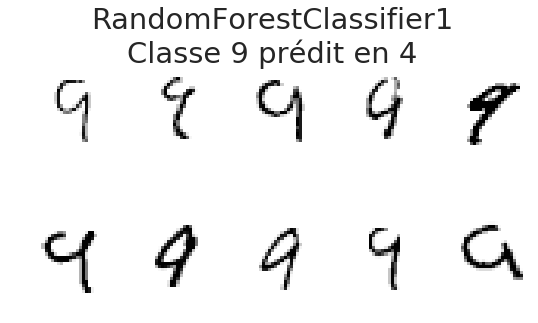

In [1823]:
studyClassif_Img.plotImgsMultiClassif(studyClassif_Mnist_Res.getObsConfused(9,4),m=[0,2])

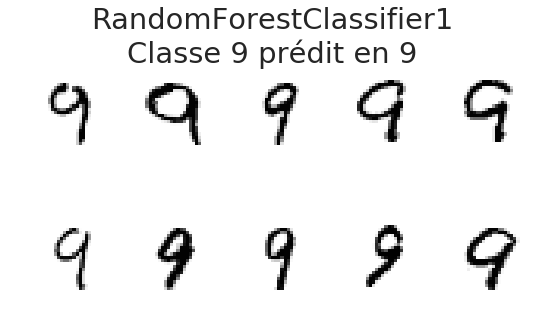

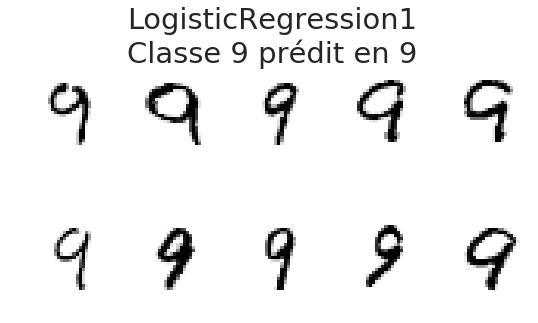

In [1824]:
studyClassif_Img.plotImgsMultiClassif(studyClassif_Mnist_Res.getObsConfused(9,9),m=[0,2])

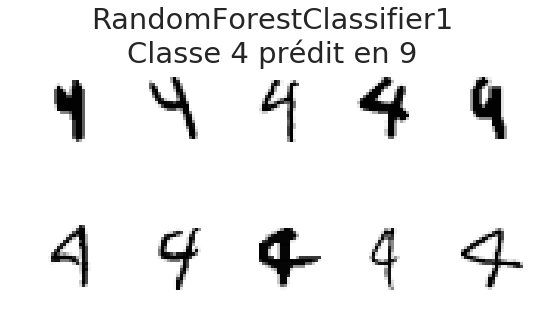

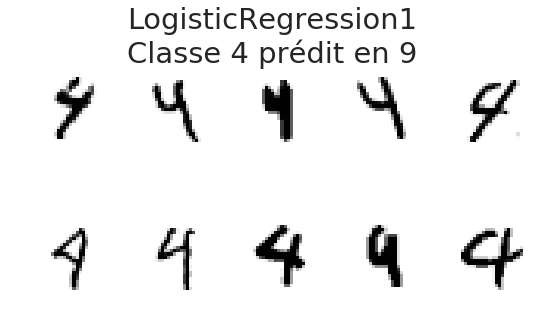

In [1826]:
studyClassif_Img.plotImgsMultiClassif(studyClassif_Mnist_Res.getObsConfused(4,9),m=[0,2])

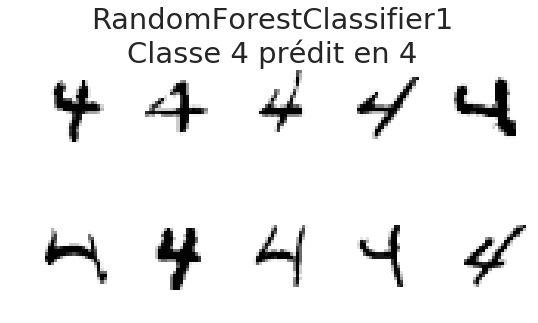

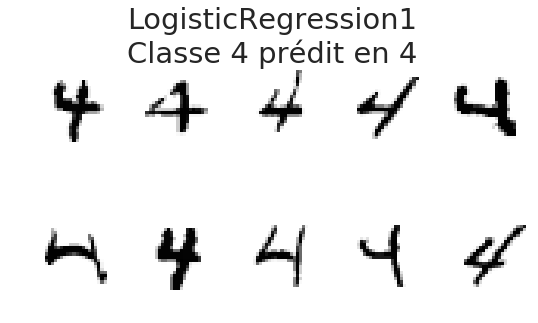

In [1827]:
studyClassif_Img.plotImgsMultiClassif(studyClassif_Mnist_Res.getObsConfused(4,4),m=[0,2])

/opt/conda/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


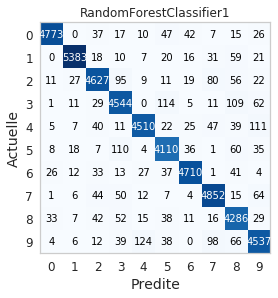

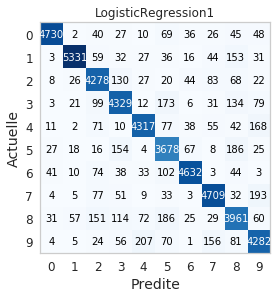

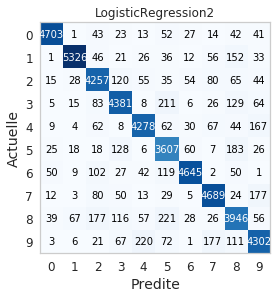

In [1828]:
studyClassif_Mnist_Res.plot_conf_matrix([0,2,3])

Precision : l’exactitude des prédictions de la classe i

Rappel: le taux d’observations de la classe i ayant bien été prédite

In [1829]:
studyClassif_Mnist_Res.classification_report(globally=True)

globally
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     19448
           1       0.95      0.98      0.96     21908
           2       0.92      0.91      0.91     19556
           3       0.91      0.90      0.90     19764
           4       0.92      0.93      0.93     18872
           5       0.91      0.87      0.89     17776
           6       0.94      0.96      0.95     19472
           7       0.94      0.93      0.93     20576
           8       0.89      0.87      0.88     18984
           9       0.89      0.90      0.90     19644

   micro avg       0.92      0.92      0.92    196000
   macro avg       0.92      0.92      0.92    196000
weighted avg       0.92      0.92      0.92    196000



In [1830]:
studyClassif_Mnist_Res.classification_report()

RandomForestClassifier1
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4862
           1       0.97      0.98      0.98      5477
           2       0.93      0.95      0.94      4889
           3       0.93      0.92      0.92      4941
           4       0.94      0.96      0.95      4718
           5       0.94      0.92      0.93      4444
           6       0.96      0.97      0.96      4868
           7       0.96      0.94      0.95      5144
           8       0.95      0.90      0.92      4746
           9       0.92      0.92      0.92      4911

   micro avg       0.95      0.95      0.95     49000
   macro avg       0.95      0.94      0.94     49000
weighted avg       0.95      0.95      0.95     49000


RandomForestClassifier2
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4862
           1       0.97      0.98      0.97      5477
           2       0.93      

In [1516]:
studyClassif_Mnist_Res.getModelsSameErrors(pct=True).T

NameError: name 'oc3' is not defined

In [1329]:
ld=VotingClassifier(list(zip(studyClassif_Mnist_Res.names[[0,3]],studyClassif_Mnist_Res.models[[0,3]])),"soft")

In [1467]:
studyClassif_Mnist_Res.y_pred

AttributeError: 'studyClassif' object has no attribute 'y_pred'

In [1352]:
stu=studyClassif([ld,studyClassif_Mnist_Res.models[0],studyClassif_Mnist_Res.models[3]],X_test,y_test,analyse=True)


In [1353]:
stu2E=stu.cross_val_score2(X_train,y_train,cv=1)

VotingClassifier
	      train  validation  test
	0      0.98         0.0  0.93
	mean   0.98         0.0  0.93
	std    0.00         0.0  0.00

RandomForestClassifier
	      train  validation  test
	0       1.0         0.0  0.95
	mean    1.0         0.0  0.95
	std     0.0         0.0  0.00

LogisticRegression
	      train  validation  test
	0      0.92         0.0  0.91
	mean   0.92         0.0  0.91
	std    0.00         0.0  0.00


In [1354]:
stu.getModelsSameErrors(pct=True)

VotingClassifier  RandomForestClassifier  \
VotingClassifier                     0.0                0.466631   
RandomForestClassifier               0.0                0.000000   
LogisticRegression                   0.0                0.000000   

                        LogisticRegression  
VotingClassifier                  0.672296  
RandomForestClassifier            0.319012  
LogisticRegression                0.000000

In [ ]:
def getObsErrors(self,i,j,lim=10,shuffle=True):
    i=self.getInd(i)
    j=self.getInd(j)
    return np.where(self.diff[2][0][1])

In [ ]:
stu.getObsErrors(0,1,lim=5)

In [1355]:
np.where(stu.diff[2][0][1])[0]

array([   59,    77,    78, ..., 48981, 48982, 48994])

In [1369]:
stu2E[0][0].predict([X_test[77]])

array([2], dtype=uint8)

In [1368]:
stu2E[1][0].predict([X_test[77]])

array([2], dtype=uint8)

In [1370]:
y_test[77]

3

In [1371]:
import scipy.ndimage as scymage

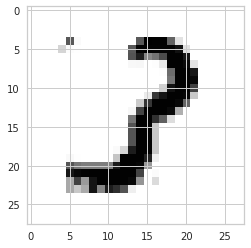

In [1366]:
plt.imshow(X_test[77].reshape((28,28)))

In [1387]:
dd=scymage.rotate(X_test[77].reshape((28,28)),angle=25,reshape=False)

In [1388]:
dd.shape

(28, 28)

In [1390]:
stu2E[0][0].predict([dd.reshape(-1)])

array([3], dtype=uint8)

In [1251]:
(studyClassif_Mnist_Res.diff[3][0] | studyClassif_Mnist_Res.diff[3][1]).sum()

3167

In [1252]:
1698/3167

0.5361540890432586

In [988]:
rnd_clf = RandomForestClassifier(n_estimators=50, random_state=42,n_jobs=-1)
cval2=cross_val_score2([rnd_clf,log_Clf],X_train,y_train,X_test,y_test,cv=3,verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.7s finished


      train  validation  test
0       1.0        0.96  0.96
1       1.0        0.96  0.96
2       1.0        0.96  0.96
mean    1.0        0.96  0.96
std     0.0        0.00  0.00


In [989]:
log_Clf = LogisticRegression(n_jobs=-1,tol=0.05)

In [990]:
cval_LogClf=cross_val_score2(log_Clf,X_train,y_train,X_test,y_test,cv=3,verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.6s finished


      train  validation  test
0      0.92        0.91  0.91
1      0.91        0.91  0.91
2      0.91        0.91  0.91
mean   0.91        0.91  0.91
std    0.00        0.00  0.00


In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


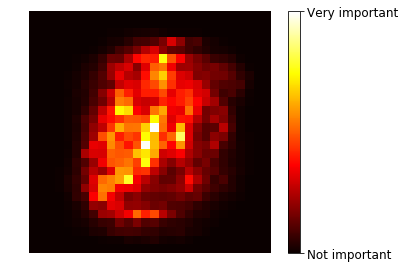

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# AdaBoost

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

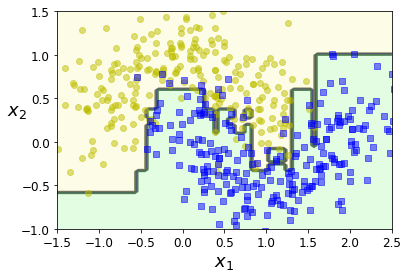

In [30]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


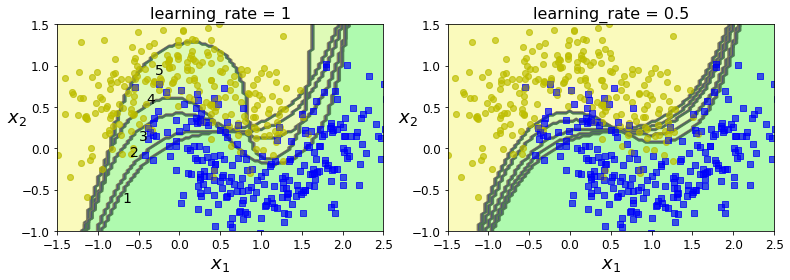

In [31]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

In [32]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting

In [33]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [34]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [35]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [36]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [37]:
X_new = np.array([[0.8]])

In [38]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [39]:
y_pred

array([0.75026781])

In [40]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


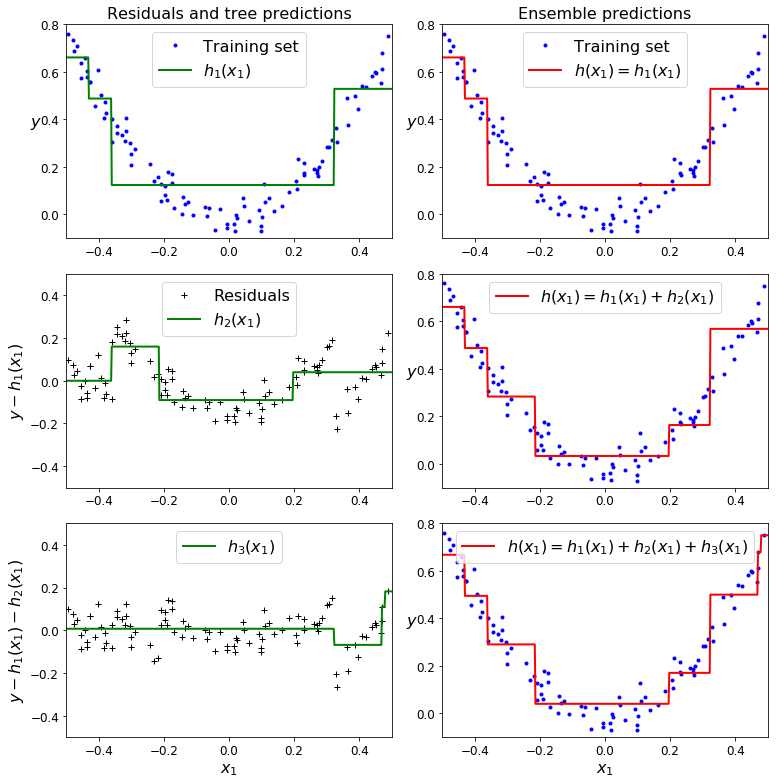

In [41]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


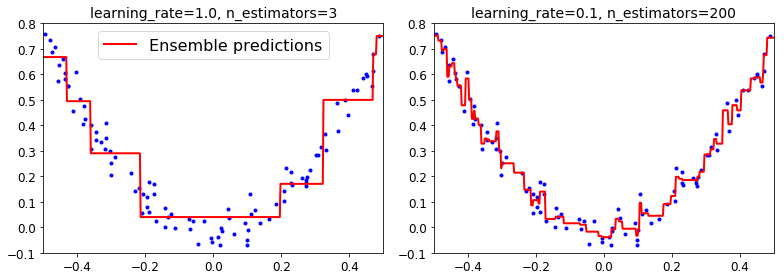

In [44]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=56, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


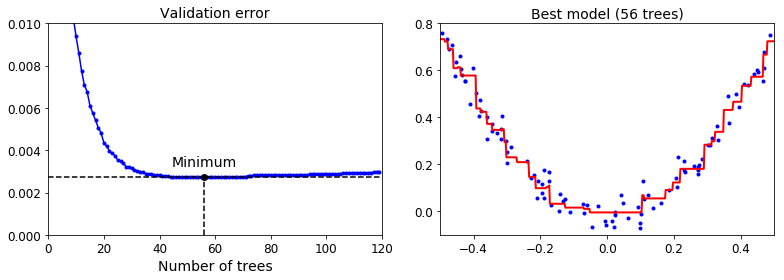

In [47]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [48]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [49]:
print(gbrt.n_estimators)

61


In [50]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## Using XGBoost

In [51]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [52]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.0028512559726563943


In [53]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

In [54]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

4.89 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

15.2 ms ± 96.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [56]:
from sklearn.model_selection import train_test_split

In [276]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

NameError: name 'mnist' is not defined

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [58]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [59]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [60]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_clas

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [61]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8641, 0.9629]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [62]:
from sklearn.ensemble import VotingClassifier

In [63]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [64]:
voting_clf = VotingClassifier(named_estimators)

In [65]:
voting_clf.fit(X_train, y_train)

/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [66]:
voting_clf.score(X_val, y_val)

0.9704

In [67]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.8641, 0.9629]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [68]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

This updated the list of estimators:

In [69]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('svm_clf', None),
 ('mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,

However, it did not update the list of _trained_ estimators:

In [70]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2',

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [71]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [72]:
voting_clf.score(X_val, y_val)

0.9739

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [73]:
voting_clf.voting = "soft"

In [74]:
voting_clf.score(X_val, y_val)

0.9704

That's a significant improvement, and it's much better than each of the individual classifiers.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [75]:
voting_clf.score(X_test, y_test)

0.9692

In [76]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9603]

The voting classifier reduced the error rate from about 4.0% for our best model (the `MLPClassifier`) to just 3.1%. That's about 22.5% less errors, not bad!

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [77]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [78]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [79]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [80]:
rnd_forest_blender.oob_score_

0.9702

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [81]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [82]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [83]:
from sklearn.metrics import accuracy_score

In [84]:
accuracy_score(y_test, y_pred)

0.9669

This stacking ensemble does not perform as well as the soft voting classifier we trained earlier, it's just as good as the best individual classifier.